In [ ]:
import cv2
import keras
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.layers import Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('gdrive/My Drive/ArtData/artists.csv')
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [ ]:
by_artist = df[['name', 'paintings']].groupby(['name'], as_index = False).sum()
name_top = by_artist.sort_values('paintings', ascending = False)[:50]
name_top


,name,paintings
48,Vincent van Gogh,877
10,Edgar Degas,702
33,Pablo Picasso,439
38,Pierre-Auguste Renoir,336
0,Albrecht Dürer,328
35,Paul Gauguin,311
15,Francisco Goya,291
42,Rembrandt,262
1,Alfred Sisley,259
46,Titian,255


In [ ]:
import glob
folders = glob.glob('gdrive/My Drive/ArtData/images/images/*')

Images = []
Labels = []
for folder in folders:
    for f in glob.glob(folder+'/*.jpg'):
        Images.append(f)
        Labels.append(folder.split('/')[-1])


In [ ]:
data = {'Artwork': Images, 'Artist': Labels}
df = pd.DataFrame(data)
df.head()

,Artwork,Artist
0,gdrive/My Drive/ArtData/images/images/Camille_...,Camille_Pissarro
1,gdrive/My Drive/ArtData/images/images/Camille_...,Camille_Pissarro
2,gdrive/My Drive/ArtData/images/images/Camille_...,Camille_Pissarro
3,gdrive/My Drive/ArtData/images/images/Camille_...,Camille_Pissarro
4,gdrive/My Drive/ArtData/images/images/Camille_...,Camille_Pissarro


In [ ]:
df = df.sample(frac=1).reset_index(drop = True)

df.head()

,Artwork,Artist
0,gdrive/My Drive/ArtData/images/images/Vincent_...,Vincent_van_Gogh
1,gdrive/My Drive/ArtData/images/images/Paul_Gau...,Paul_Gauguin
2,gdrive/My Drive/ArtData/images/images/Vincent_...,Vincent_van_Gogh
3,gdrive/My Drive/ArtData/images/images/Pierre-A...,Pierre-Auguste_Renoir
4,gdrive/My Drive/ArtData/images/images/Paul_Cez...,Paul_Cezanne


(858, 1280, 3) Artist : Vincent_van_Gogh


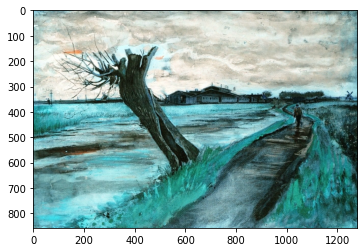

In [ ]:
img = cv2.imread(df['Artwork'].iloc[0])
plt.imshow(img)
print(str(img.shape)+" Artist : "+str(df['Artist'].iloc[0]))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1./255., zoom_range=0.2, rotation_range=0.2, horizontal_flip=True, 
                               vertical_flip=True,shear_range=0.2, validation_split=0.25)

In [ ]:
train_generator = train_gen.flow_from_dataframe(df, directory='', x_col='Artwork', y_col='Artist', batch_size=32,
                                                subset="training", seed=42, target_size=(299,299), shuffle=True)

valid_generator = train_gen.flow_from_dataframe(df, directory='', x_col='Artwork', y_col='Artist', batch_size=32,
                                                subset="validation", seed=42, target_size=(299,299), shuffle=True)

Found 6335 validated image filenames belonging to 50 classes.
Found 2111 validated image filenames belonging to 50 classes.


In [ ]:
from keras.models import Model
from keras.applications import InceptionResNetV2
baseModel = InceptionResNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(299, 299, 3)))

x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(50, activation="softmax")(x)

'''headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(512, activation='relu')(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(256, activation='relu')(headModel)
headModel = Dense(50, activation='softmax')(headModel)'''
 
model = Model(inputs=baseModel.input, outputs=predictions)
model.summary()




219062272/219055592 [==============================] - 1s 0us/step
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 149, 149, 32) 96          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_8[0][0]      
____________________

In [ ]:
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', verbose=1,patience=3, mode='min')
]

In [ ]:
from keras import optimizers 
model.compile(loss ='categorical_crossentropy',optimizer = optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,steps_per_epoch = train_generator.n//train_generator.batch_size,
                              validation_data= valid_generator,validation_steps= valid_generator.n//valid_generator.batch_size
                              ,epochs = 50,callbacks=keras_callbacks)

Epoch 1/50
197/197 [==============================] - 352s 2s/step - loss: 3.1679 - accuracy: 0.2167 - val_loss: 2.3536 - val_accuracy: 0.4019
Epoch 2/50
197/197 [==============================] - 346s 2s/step - loss: 2.0157 - accuracy: 0.4855 - val_loss: 1.7856 - val_accuracy: 0.5486
Epoch 3/50
197/197 [==============================] - 347s 2s/step - loss: 1.3770 - accuracy: 0.6262 - val_loss: 1.3262 - val_accuracy: 0.6534
Epoch 4/50
197/197 [==============================] - 346s 2s/step - loss: 0.9777 - accuracy: 0.7317 - val_loss: 1.4913 - val_accuracy: 0.6510
Epoch 5/50
197/197 [==============================] - 346s 2s/step - loss: 0.7544 - accuracy: 0.7888 - val_loss: 1.1861 - val_accuracy: 0.7197
Epoch 6/50
197/197 [==============================] - 348s 2s/step - loss: 0.5965 - accuracy: 0.8321 - val_loss: 1.1401 - val_accuracy: 0.7173
Epoch 7/50
197/197 [==============================] - 350s 2s/step - loss: 0.4804 - accuracy: 0.8685 - val_loss: 1.0708 - val_accuracy: 0.7389

In [ ]:
score = model.evaluate(valid_generator, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.4885363578796387
Test accuracy: 0.7110373973846436


In [ ]:
predictions = model.predict(valid_generator)

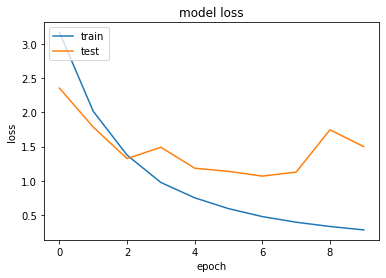

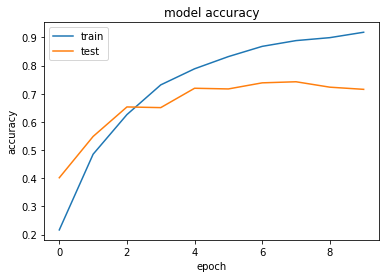

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()